# October 15th, 2021

## Tasks:
- Save colormaps for all time, ***t***, and microstructure, ***m***

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

# Data pre-processing with Pandas
import pandas as pd

# To read metadata
import json

# To round numbers up
from math import ceil

# To interpolate the grid for z = f(x, y)
from scipy.interpolate import griddata

# To save the image
from PIL import Image

# Operating system manipulations
import os

In [2]:
# Wrapper to avoid getting having to index everytime to discard the
# transparency value when calling the colormap
class nice_cm:
    def __init__(self, color: str):
        self.cm = cm.get_cmap(color)
    def __call__(self, val: np.array):
        return self.cm(val)[:, :3]

In [3]:
col_map = nice_cm('plasma')

In [4]:
# Electrode geometry (um), use this to construct dimension of blank image
L_pos = 176
h_cell = 100

In [5]:
# Scale increase the resolution of the blank image by
SCALE = 10

# Unit conversion from meter to um
to_um = 1e-6

# Unit conversion from um to pixel
to_pix = 1e6 * SCALE

# RGB Dimension
RGB_dim = 3

In [6]:
# Hard-coded value where header lives ~ should be constant across COMSOL-generated files
HEADER_ROW = 8

# Directories where the "electro_c-rate.csv"
MICRO_DIRS = os.listdir(os.getcwd())
# Parses out only directories - i.e., not png/json/ipynb files
MICRO_DIRS = [file for file in MICRO_DIRS 
              if not any(True for substr in ['.png', '.json', '.ipynb', '.DS_Store'] if substr in file)]
MICRO_DIRS.sort()
MICRO_DIRS = [os.path.join(os.getcwd(), dirr) for dirr in MICRO_DIRS]

# List of C-rates used for experimental discharge
C_RATES = ['0.33', '1', '2']

# Formats the electrochem filename
def get_electrochem_csv(c_rate: str) -> str:
    fname = "electro_%s.csv" % (c_rate)
    return fname

In [7]:
def get_SoL(df: pd.DataFrame, col: int) -> np.array:
    # Gets the SoL value at the column number representing
    # some timestep
    return df.iloc[:, col]

In [8]:
# Read the JSON data file
f = open("metadata.json", "r")

# Housing for microstructures
microstructures = json.load(f)

In [9]:
# The mappings to convert micrometers to pixel values
def map_x(x):
    x = np.ceil( x * to_pix) - 1
    return x

def map_y(y):
    y = np.ceil( y * to_pix) - 1
    return y

In [ ]:
for l, micro in enumerate(microstructures):    
    # Get the path to the microstructure for file read/write
    micro_path = MICRO_DIRS[l]
    
    for c_rate in C_RATES:
        # Helpful print statement to indicate progress
        print(("Microstructure: %d C-rate: %s") % (l + 1, c_rate))
        
        # Get the electrochem file
        discharge_fname = get_electrochem_csv(c_rate)
        csv_path = os.path.join(micro_path, discharge_fname)
        
        print(csv_path)
        
        # Load CSV file into Pandas Dataframe object
        # At this size, should not require buffering
        dataframe = pd.read_csv(csv_path, header=HEADER_ROW)

        # Store the X and Y columns for indexing - avoid magic numbers
        X_col = dataframe.columns[0]
        Y_col = dataframe.columns[1]

        # Drops all NaN values from the table
        dataframe = dataframe.dropna()

        # Get the number of columns
        _, NUM_COL = dataframe.shape
        
        # Normalize % of charge to 0 - 1 scale
        dataframe.iloc[:, 2:] = dataframe.iloc[:, 2:] / 100
        
        # Get the (X, Y) and SoL values corresponding to the vertices that
        # already have color from COMSOL
        X, Y = dataframe[X_col].to_numpy(), dataframe[Y_col].to_numpy()

        # From micrometer- to pixel-scale
        X = map_x(X)
        Y = map_y(Y)
        
        for t in range(2, NUM_COL):
            # Create blank image to house SoL data from CSV files
            im = np.zeros((h_cell * SCALE, L_pos * SCALE, RGB_dim))

            # Already filled SoL values
            avail_sol = get_SoL(dataframe, t)

            # Assume that we'll get roughly the same min and max for the
            # pre-filled data as we would for the population
            sol_min = np.min(avail_sol)
            sol_max = np.max(avail_sol)

            # To indicate SoL
            sol_str = "Min SoL: %.2f, Max SoL: %.2f" % (sol_min, sol_max)

            ## Fill in image with color values that are already present
            # Let's fill in the image with the pre-filled vertices
            # Use normalized SoL for now
            t_init_df = col_map((avail_sol - sol_min)/(sol_max - sol_min))
            # For normal use, just use SoL as is
            # t_init_df = col_map(avail_sol)

            for k, x in enumerate(X):
                x = int(x)
                y = int(Y[k])
                im[y, x, :] = t_init_df[k]

            time = dataframe.columns[t].split(" ")
            time = time[-1].split("=")[-1]

            print(sol_str)
            print("Time=", time, "s")

            ## Using the normalized State-of-Lithiation
            for i in range(len(micro['circles'])):
                print(i)
                curr_circ = micro['circles'][i]

                # Define co-ordinates to box in a circle
                x_min = (float(curr_circ['x']) - float(curr_circ['R'])) * to_um
                x_max = (float(curr_circ['x']) + float(curr_circ['R'])) * to_um
                y_min = (float(curr_circ['y']) - float(curr_circ['R'])) * to_um
                y_max = (float(curr_circ['y']) + float(curr_circ['R'])) * to_um

                # Filter the original dataframe for pre-filled (x,y)
                x_filt = dataframe[dataframe[X_col].between(x_min, x_max)]
                y_filt = x_filt[x_filt[Y_col].between(y_min, y_max)]

                # Pre-filled co-ordinates for the "curr_circ"
                x_circ, y_circ = y_filt[X_col].to_numpy(), y_filt[Y_col].to_numpy()

                # Generate linearly spaced arrays to interpolate data on
                #
                # Hard-coded 1000 but should be fine unless we're going to change
                # the dimensions of the blank image
                x_linspace = np.linspace(x_min, x_max, num = 1000)
                y_linspace = np.linspace(y_min, y_max, num = 1000)

                # Generate a grid for the box encapsulating the "curr_circ"
                xx, yy = np.meshgrid(x_linspace, y_linspace)

                # Circle parameters: radius and center, (x_c, y_c)
                R = float(curr_circ['R']) * to_um
                x_c = float(curr_circ['x']) * to_um
                y_c = float(curr_circ['y']) * to_um

                # Determine the coordinates that are within the circle
                in_circ = np.sqrt((xx - x_c) ** 2 + (yy - y_c) ** 2) <= R

                ## Retrieve coordinates that are within the circle
                xx = xx[in_circ]
                yy = yy[in_circ]

                # Get pre-filled (x,y) and SoL ready for interpolation
                points_in_circ = np.array([x_circ, y_circ])
                points_in_circ = points_in_circ.T
                SoL = y_filt.iloc[:, t].to_numpy()

                grid_z = griddata(points_in_circ, SoL, (xx, yy), method='linear')

                filled_in_values = pd.DataFrame(
                    {X_col: xx,
                     Y_col: yy, 
                     dataframe.columns[t]: grid_z})

                filled_in_values = filled_in_values.dropna()

                x_fill = filled_in_values[X_col].to_numpy()
                y_fill = filled_in_values[Y_col].to_numpy()
                sol_fill  = filled_in_values.iloc[:, 2].to_numpy()

                # Convert from micrometer- to pixel-scale
                x_fill = map_x(x_fill)
                y_fill = map_y(y_fill)

                # To see if the neural net will see different values
                # we'll normalize the SoL and validate visually that
                # these values are not "too" close to each other
                sol_norm = (sol_fill - sol_min)/(sol_max - sol_min)

                # Change this later to use "sol_fill"
                col_fill = col_map(sol_norm)

                for j, x in enumerate(x_fill):
                    x = int(x) if int(x) < L_pos * SCALE else L_pos * SCALE - 1
                    y = int(y_fill[j])
                    im[y, x, :] = col_fill[j]

            ## Show and save the image
            plt.imshow(im, origin='lower')

            # Need to convert from float to int, as per: 
            #     https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
            im = Image.fromarray((im * 255).astype(np.uint8))
            out_path = os.path.join(micro_path, "col/")
            try:
                os.mkdir(out_path)
            except FileExistsError:
                pass
            filename = "c%s_t%s.png" % (c_rate, time)
            filename = os.path.join(out_path, filename)
            im.save(filename)

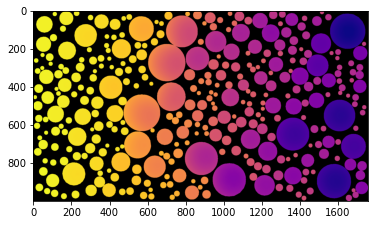

In [13]:
plt.imshow(im)

In [12]:
# (Hamed) For image extraction near corners:
# - numpy.padding